# Problem Statement: 
**Predict car dwell time at Rumford Station:**

---
Exploratory data analysis on RUM station inventory during 2017-2018

---

### Shortcomings:
The resolution of the dwell hours predicted is limited to 24 hours as the inventory list is generated once per day.  
The dataset consists of majority catagorical variables that need to be properly mapped for models to work well with them. It could prove difficult to predict a continous numerical variable from them.  
There are many more boxcars than other kinds of cars in the dataset.

### Next steps
Map all the catagorical variables.
Decide how to hand the missing recieved dates.

---
# Import Data
---


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
fn = r"C:\Users\Lenovo Thinkpad W520\Documents\Data Science\Projects\Final Project\Datasets\Online Snapshot.xlsx"
df = pd.read_excel(fn)
df.head()

,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Placement Ind,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time
0,CAR1 0594,E,B357,B,Box Cars,N,5507,55,7,,...,Y,N,2018-07-03,1050.0,24,7.283333,,0.64,2018-08-17,617
1,CAR1 0594,E,B357,B,Box Cars,N,5507,55,7,,...,Y,N,2018-07-03,1050.0,48,31.116667,,0.64,2018-08-18,607
2,CAR1 0594,E,B357,B,Box Cars,N,5507,55,7,,...,Y,N,2018-07-03,1050.0,73,55.950000,,0.64,2018-08-19,657
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616


### What does the data look like?
---
Resuslts Summary:   
- 35 colulmns and 79671 rows
    - Each enrtry is a specific car parked at RUM
- Missing 2084 entries from received date and time
- Missing 'Car Kind' values are engines
- Other missing values in object type columns will be filled in with the most common category of that feature.
    - This should be a reasonable way to handle missing values because many of the most common categories have a large majority.
- Data types are strings, numerical and datetime
- 640 entries of the data to be predicted (Dwell Hours) is negative
    - Cars with these negative dwell hours will be considered not to be dwelling.

In [4]:
df.dtypes

Equipment ID                          object
LE Status                             object
AAR Car Type                          object
AAR Car Kind                          object
AAR Car Type Description              object
System Car                            object
Length                                 int64
Feet                                   int64
Inches                                 int64
Bad Order Ind                         object
Track ID                              object
STCC                                  object
STCC Description                      object
Weight                                 int64
Tare Weight                            int64
Last Move Type                        object
Last Move Date                datetime64[ns]
Last Move Time                         int64
Shipper Customer ID                   object
Block To Customer ID                  object
Block To Address Type                 object
Switch To                             object
Switch To 

In [5]:
df.shape

(79671, 35)

In [6]:
df.isnull().sum()

Equipment ID                     0
LE Status                        0
AAR Car Type                     0
AAR Car Kind                     0
AAR Car Type Description         0
System Car                       0
Length                           0
Feet                             0
Inches                           0
Bad Order Ind                    0
Track ID                         0
STCC                             0
STCC Description                 0
Weight                           0
Tare Weight                      0
Last Move Type                   0
Last Move Date                   0
Last Move Time                   0
Shipper Customer ID              0
Block To Customer ID             0
Block To Address Type            0
Switch To                        0
Switch To Address Type           0
Switch To Customer ID            0
Traffic Type                     0
Placement Ind                    0
Constructive Placement Ind       0
Received Date                 2084
Received Time       

C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'frequency')

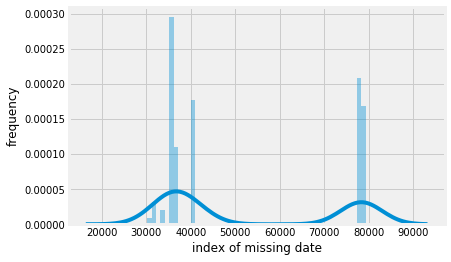

In [7]:
# The missing received date data seem to be clusted together in index (and also time). Ignoring these my introduce bias.
ax = sns.distplot(df['Received Date'][df['Received Date'].isnull()==True].index,bins=50)
ax.set_xlabel('index of missing date')
ax.set_ylabel('frequency')

In [8]:
(df['Dwell Hours'] <=0).sum()

640

---
# Find Car Dwell Times (This will be the target to be predicted):
---
This target needs to be extracted from the data because it is not explicitly listed. The 'Dwell Hours' column is cumulative, and the local maximums for this column car would need to be extracted to determine the overall dwell time for that car.

---
Conditions for car "dwelling":    
1. The car is destined for somewhere other than Rumford Station.    
         "Block To" != "RUMMIL"
2. The car is not damaged.
         "Bad Order" is empty
3. The car is not being stored.
         "Storage Ind" != Y
4. The customer has not taken possesion of the car.
         "Placement Ind" == N
---
Results Summary:    
- Min and max indexes appear accurate
- The resulting DataFrame consists of 11049 car dwell times to train and test on with at most 34 potential feature columns

In [9]:
# Return a mask of the dwelling car conditions
def dwell_mask(df):
    msk_dwell = ((df[ 'Block To Customer ID'] != 'RUMMIL   ')                                  # The car is destined for somewhere else
                        & (df['Bad Order Ind'] == ' ')                                         # The car is not damaged
                        & (df['Storage Ind'] != 'Y')                                           # The car is not in storage
                        & (df['Placement Ind'] != 'Y')                                         # The car is not in the possesion of the customer
                )
    return msk_dwell

In [10]:
# Filter the full DataFrame for inventory logs of dwelling cars only

df_dwell = df[dwell_mask(df)]
df_dwell.head()

,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Placement Ind,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616
9,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-05,1931.0,112,6.650000,,0.64,2018-09-16,659
17,CAR1 1385,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-08,2032.0,112,2.783333,,0.64,2018-09-20,610
18,CAR1 1385,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-08,2032.0,0,1.116667,,0.64,2018-09-21,613


In [11]:
# Pull out the dwell start data. Cars that leave the station and come back will have multiple dwell starts.
df_min_dwell = df_dwell[(df_dwell['Dwell Hours'].shift(1) >= df_dwell['Dwell Hours']) 
                  & (df_dwell['Dwell Hours'].shift(-1) >= df_dwell['Dwell Hours'])
                  | (df_dwell.index == df_dwell.index.min())]

In [12]:
# Pull out the max dwell hours. Cars that leave the station and come back will have multiple departures. Maxima are needed because dwell hours are cumulative.
df_max_dwell = df_dwell[(df_dwell['Dwell Hours'].shift(1) < df_dwell['Dwell Hours']) 
                  & (df_dwell['Dwell Hours'].shift(-1) < df_dwell['Dwell Hours'])] 
#                   | (df_dwell.index == df_dwell.index.max())
#                   | (df_dwell.index == df_dwell.index.min())]

In [13]:
# Carefully zip corresponding arrival and departures, finding the departures for each arrival.
max_dwell = []
for row in df_min_dwell.index:
    next_max = df_max_dwell[(df_max_dwell['Create Date'] > df_min_dwell['Create Date'][row]) #create date is after
                & (df_max_dwell['Equipment ID'] == df_min_dwell['Equipment ID'][row])# Equip ID is the same)
                             ]
    try:
        next_max = next_max['Dwell Hours'][next_max.index.min()]
    except KeyError:
        next_max = np.nan
    max_dwell.append(next_max)

#Show that the dimensions match
print(len(df_min_dwell))
print(len(max_dwell))

11872
11872


In [14]:
df_dwell

,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Placement Ind,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616
9,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-05,1931.0,112,6.650000,,0.64,2018-09-16,659
17,CAR1 1385,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-08,2032.0,112,2.783333,,0.64,2018-09-20,610
18,CAR1 1385,L,B357,B,Box Cars,N,5507,55,7,,...,N,N,2018-09-08,2032.0,0,1.116667,,0.64,2018-09-21,613
19,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,N,Y,2018-07-06,1020.0,9,5.683333,,0.64,2018-07-15,643
20,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,N,Y,2018-07-06,1020.0,33,29.183333,,0.64,2018-07-16,613
21,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,N,Y,2018-07-06,1020.0,57,53.183333,,0.64,2018-07-17,613
22,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,N,Y,2018-07-06,1020.0,81,77.183333,,0.64,2018-07-18,613
23,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,N,Y,2018-07-06,1020.0,105,101.200000,,0.64,2018-07-19,614


In [15]:
# Create a new column for the target (maximum dwell time) in the minimum dwell time dataframe which contains our potential features. This new Dataframe will be the dataframe to train and test on
df_trains = df_min_dwell
df_trains['Max Dwell Hours'] = max_dwell
df_trains.head(20)

C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time,Max Dwell Hours
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608,6.650000
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616,6.650000
18,CAR1 1385,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-08,2032.0,0,1.116667,,0.64,2018-09-21,613,NaN
29,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-06,1020.0,249,-14.916667,,0.64,2018-07-25,605,8.183333
40,CAR1 1387,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-08-10,100.0,4,4.500000,,0.64,2018-08-22,615,NaN
65,CAR1 1876,E,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-12,820.0,17,17.733333,,0.64,2018-09-16,659,40.950000
72,CAR1 1876,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-12,820.0,186,3.683333,,0.64,2018-09-23,722,NaN
81,CAR1 1943,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-03,1050.0,13,5.733333,,0.64,2018-07-12,614,56.583333
86,CAR1 1973,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-03,1050.0,13,5.733333,,0.64,2018-07-12,614,NaN
125,CAR1 2264,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-02,1035.0,27,22.233333,,0.64,2018-07-11,614,70.200000


### We only want to use the data available upon arrival of the car:

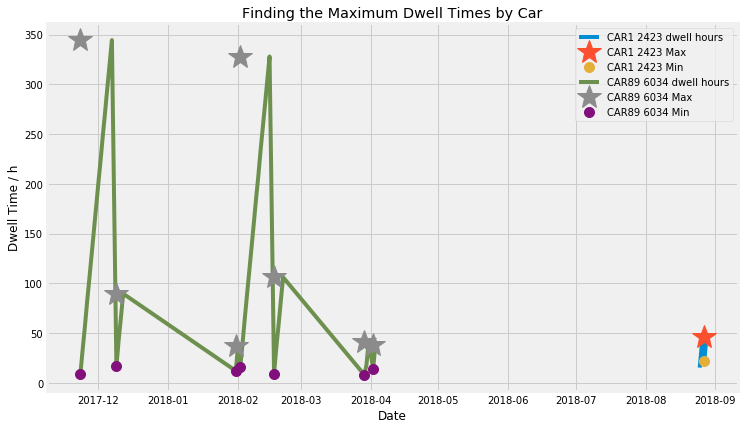

In [16]:
# Check that the maxima correspond to the appropriate arrival data (looks good)

car1 = 'CAR1 2423'
car2 = 'CAR89 6034'
cars = [car1,car2]

fig,ax = plt.subplots(figsize=(12,7))
plt.gcf().subplots_adjust(left=0.15) # make room for labels
plt.gcf().subplots_adjust(bottom=0.15) # make room for labels

for car in cars:
    ax.plot(df_dwell['Create Date'][df_dwell['Equipment ID']==car],df_dwell['Dwell Hours'][df_dwell['Equipment ID']==car], label = str(car+' dwell hours'))
    ax.plot(df_trains['Create Date'][df_trains['Equipment ID']==car],df_trains['Max Dwell Hours'][df_trains['Equipment ID']==car],
            linestyle='None',
            markersize = 25,
            marker = '*',
            label = car+' Max')
    ax.plot(df_trains['Create Date'][df_trains['Equipment ID']==car],df_trains['Dwell Hours'][df_trains['Equipment ID']==car],
            linestyle='None',
            markersize = 10,
            marker = 'o',
            label = car+' Min')

leg = ax.legend()
ax.set_title('Finding the Maximum Dwell Times by Car')
ax.set_ylabel('Dwell Time / h')
ax.set_xlabel('Date');

In [17]:
# Cull unpaired arrivals/departures
print(len(df_trains))
print(df_trains['Max Dwell Hours'].isnull().sum())
df_trains = df_trains[df_trains['Max Dwell Hours'].notnull()]
print(len(df_trains))

11872
823
11049


In [18]:
df_trains.head(50)

,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time,Max Dwell Hours
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608,6.650000
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616,6.650000
29,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-06,1020.0,249,-14.916667,,0.64,2018-07-25,605,8.183333
65,CAR1 1876,E,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-12,820.0,17,17.733333,,0.64,2018-09-16,659,40.950000
81,CAR1 1943,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-03,1050.0,13,5.733333,,0.64,2018-07-12,614,56.583333
125,CAR1 2264,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-02,1035.0,27,22.233333,,0.64,2018-07-11,614,70.200000
134,CAR1 2304,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,73,2.633333,,0.64,2018-08-19,657,14.116667
155,CAR1 2344,E,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-12,820.0,64,5.683333,,0.64,2018-09-18,611,53.666667
161,CAR1 2361,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-19,1035.0,22,14.083333,,0.64,2018-07-25,605,38.216667
163,CAR1 2361,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-19,1035.0,70,15.450000,,0.64,2018-07-27,604,63.850000


# Now that the features and target are together, what does the target look like?
---
- Dwell times are right skewed with the mean and median dwell times being much closer to the minimum than maximum

In [19]:
# Dwell time by Car kind
df_trains.groupby('AAR Car Kind')['Max Dwell Hours'].describe()

,count,mean,std,min,25%,50%,75%,max
AAR Car Kind,,,,,,,,
,17.0,176.889216,267.728855,13.100000,37.650000,41.716667,69.183333,784.616667
A,5130.0,77.642758,98.736082,3.500000,33.400000,51.558333,82.008333,1408.916667
B,147.0,85.223243,81.013291,6.650000,39.225000,61.683333,100.450000,365.100000
C,737.0,106.379240,107.867196,7.766667,39.866667,64.216667,128.183333,858.233333
D,73.0,110.447032,164.305804,4.483333,17.733333,33.400000,124.133333,1030.483333
E,3.0,65.816667,27.510740,34.050000,57.875000,81.700000,81.700000,81.700000
F,68.0,59.792647,39.379606,10.800000,32.750000,40.050000,78.433333,174.033333
G,17.0,297.582353,507.174616,32.216667,87.150000,135.600000,285.216667,2176.050000
H,257.0,155.046304,236.601046,8.400000,38.350000,62.066667,126.266667,1432.083333


In [20]:
# Dwell time by Car type
df_trains.groupby('AAR Car Type')['Max Dwell Hours'].describe()

,count,mean,std,min,25%,50%,75%,max
AAR Car Type,,,,,,,,
,17.0,176.889216,267.728855,13.100000,37.650000,41.716667,69.183333,784.616667
A302,32.0,60.988021,45.246411,12.666667,37.625000,52.050000,79.558333,257.683333
A305,2.0,60.883333,60.033366,18.433333,39.658333,60.883333,82.108333,103.333333
A332,2.0,79.833333,93.526657,13.700000,46.766667,79.833333,112.900000,145.966667
A402,2760.0,81.726576,113.272473,3.500000,33.200000,51.858333,84.633333,1408.916667
A403,97.0,106.680928,148.858457,14.600000,41.233333,60.033333,88.816667,835.266667
A405,1479.0,71.468244,68.223396,5.200000,33.766667,51.300000,80.725000,826.116667
A406,514.0,69.394780,69.822363,6.083333,30.737500,47.908333,79.266667,654.533333
A432,228.0,78.487719,110.479437,6.483333,35.000000,48.833333,78.650000,933.133333


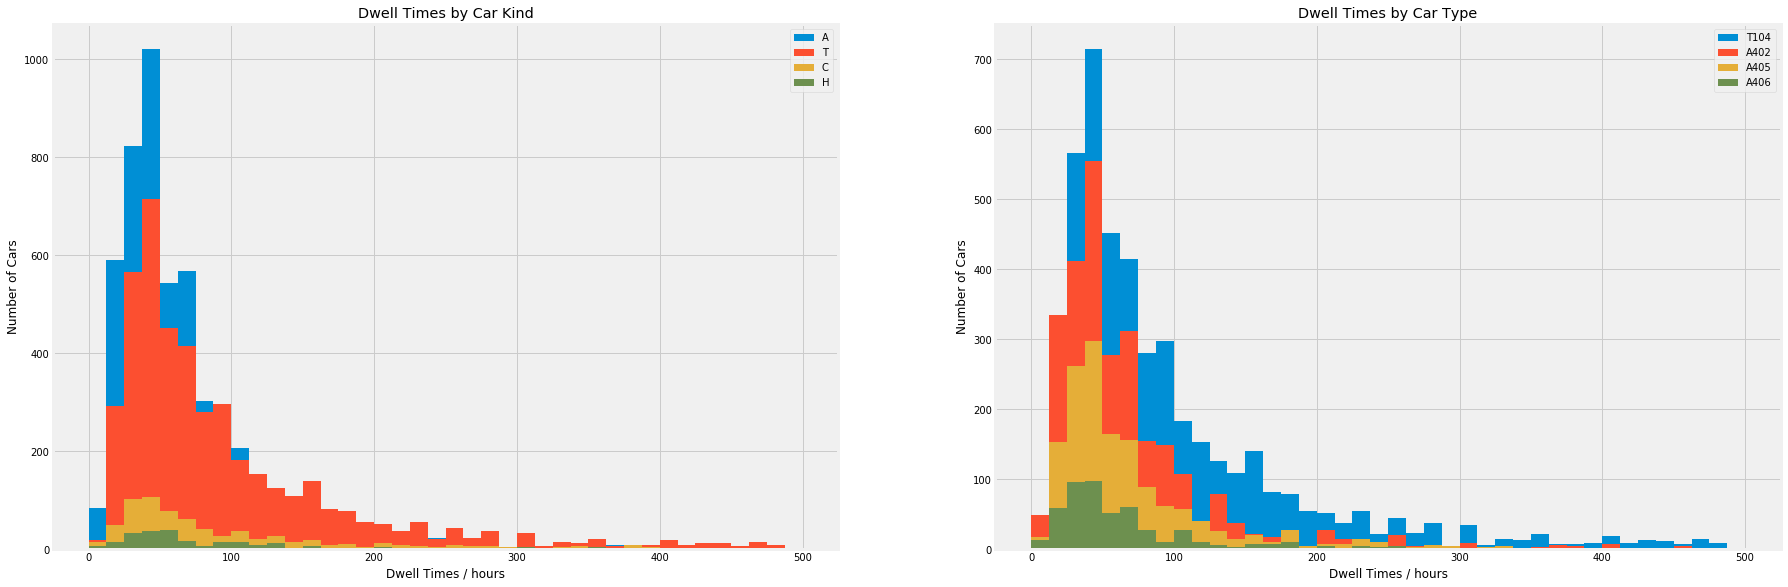

In [21]:
# Distributions of the most used train cars
fig, (ax1,ax2)  = plt.subplots(ncols=2,nrows=1,figsize=(30,10))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15) 

car_kinds = list(df_trains['AAR Car Kind'].value_counts()[0:4].index)
car_types = list(df_trains['AAR Car Type'].value_counts()[0:4].index)

for car in car_kinds:
    ax1.hist(df_trains.groupby('AAR Car Kind').get_group(car)['Max Dwell Hours'],label = car, bins=40,range=(0,500))

for car in car_types:
    ax2.hist(df_trains.groupby('AAR Car Type').get_group(car)['Max Dwell Hours'],label = car, bins=40,range=(0,500))

ax1.set_xlabel('Dwell Times / hours')
ax1.set_ylabel('Number of Cars')
ax1.set_title('Dwell Times by Car Kind')
leg = ax1.legend()

ax2.set_xlabel('Dwell Times / hours')
ax2.set_ylabel('Number of Cars')
ax2.set_title('Dwell Times by Car Type')
leg = ax2.legend();


In [22]:
df_trains.corr()

,Length,Feet,Inches,Weight,Tare Weight,Last Move Time,Received Time,Hours at Station,Dwell Hours,Car Hire Rate,Create Time,Max Dwell Hours
Length,1.000000,0.999988,-0.089587,-0.170117,0.303164,-0.026499,0.157716,0.016072,-0.045310,0.495579,0.022442,-0.100297
Feet,0.999988,1.000000,-0.094482,-0.170320,0.303137,-0.026604,0.157551,0.016158,-0.045335,0.495397,0.022464,-0.100101
Inches,-0.089587,-0.094482,1.000000,0.056673,-0.022298,0.023691,0.020500,-0.018859,0.009325,-0.008820,-0.006664,-0.030536
Weight,-0.170117,-0.170320,0.056673,1.000000,0.132545,-0.157772,-0.000434,-0.103370,-0.080784,-0.051072,-0.011893,0.119735
Tare Weight,0.303164,0.303137,-0.022298,0.132545,1.000000,-0.046948,0.122310,-0.040211,-0.029625,0.108185,0.001429,-0.037497
Last Move Time,-0.026499,-0.026604,0.023691,-0.157772,-0.046948,1.000000,-0.000912,0.122668,0.272155,-0.017404,-0.072140,-0.013302
Received Time,0.157716,0.157551,0.020500,-0.000434,0.122310,-0.000912,1.000000,-0.047910,-0.024221,0.088807,0.040440,-0.055157
Hours at Station,0.016072,0.016158,-0.018859,-0.103370,-0.040211,0.122668,-0.047910,1.000000,0.174869,0.043332,0.014024,-0.046057
Dwell Hours,-0.045310,-0.045335,0.009325,-0.080784,-0.029625,0.272155,-0.024221,0.174869,1.000000,-0.023557,0.039858,0.087000
Car Hire Rate,0.495579,0.495397,-0.008820,-0.051072,0.108185,-0.017404,0.088807,0.043332,-0.023557,1.000000,0.036391,-0.089764


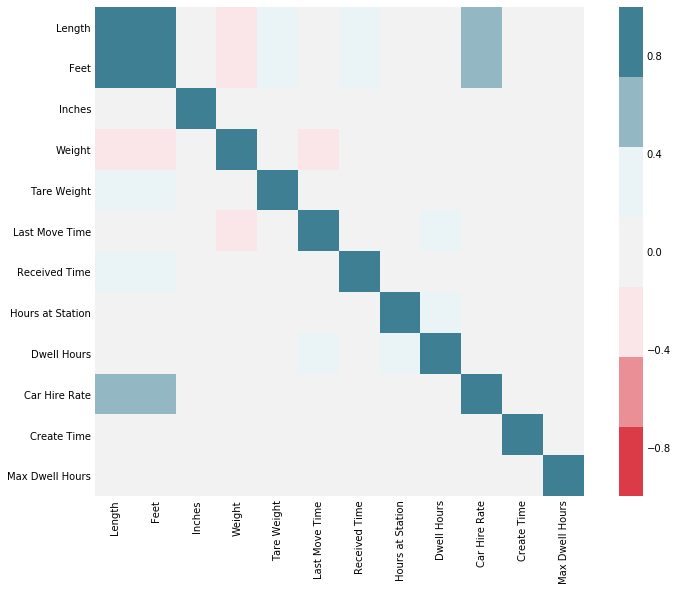

In [23]:
# The numeric columns are not correlated with car dwell times.
fig, ax = plt.subplots(figsize=(12,10))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.2)

ax = sns.heatmap(df_trains.corr(), vmax=1, vmin=-1, square=True, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

# What about the non-numerical features
---
Value counts of the various categories listed in the object features are pretty unbalanceed

In [24]:
# How diverse are the categorical features?:
object_cols = df_trains.columns[(df_trains.dtypes == object)]

for obj in object_cols:
    print(obj+': '+str(len(df_trains[obj].unique())))

Equipment ID: 2453
LE Status: 5
AAR Car Type: 38
AAR Car Kind: 12
AAR Car Type Description: 9
System Car: 2
Bad Order Ind: 1
Track ID: 35
STCC: 29
STCC Description: 18
Last Move Type: 16
Shipper Customer ID: 34
Block To Customer ID: 32
Block To Address Type: 18
Switch To: 32
Switch To Address Type: 16
Switch To Customer ID: 31
Traffic Type: 4
Placement Ind: 1
Constructive Placement Ind: 2
Storage Ind: 1


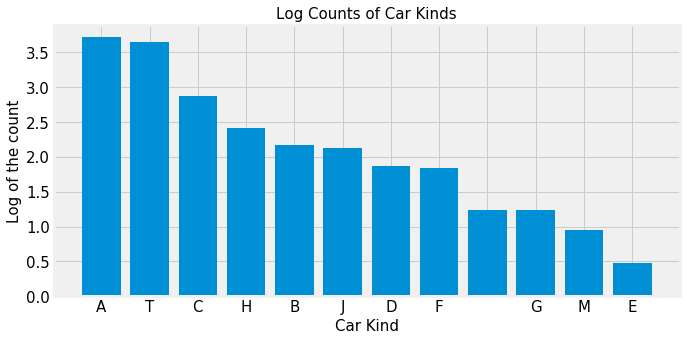

In [35]:
#Far more boxcars than other cars (it's on a log scale)
fig,ax = plt.subplots(figsize=(10,5))


data= df_trains['AAR Car Kind'].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel('Car Kind', fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Log Counts of Car Kinds',fontsize=fontsize);

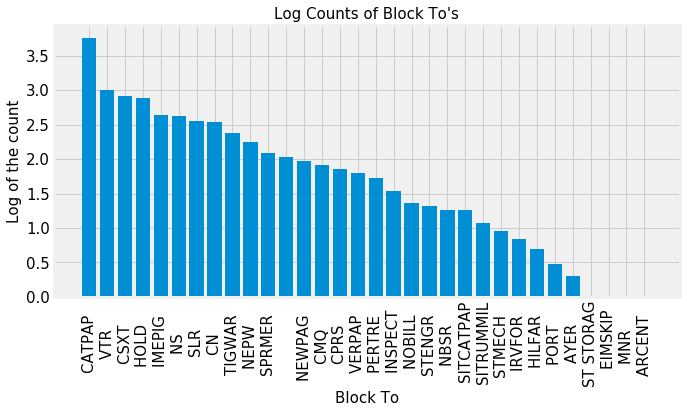

In [26]:
fig,ax = plt.subplots(figsize=(10,5))


data= df_trains['Block To Customer ID'].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel('Block To', fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title("Log Counts of Block To's",fontsize=fontsize)
plt.xticks(rotation=90);

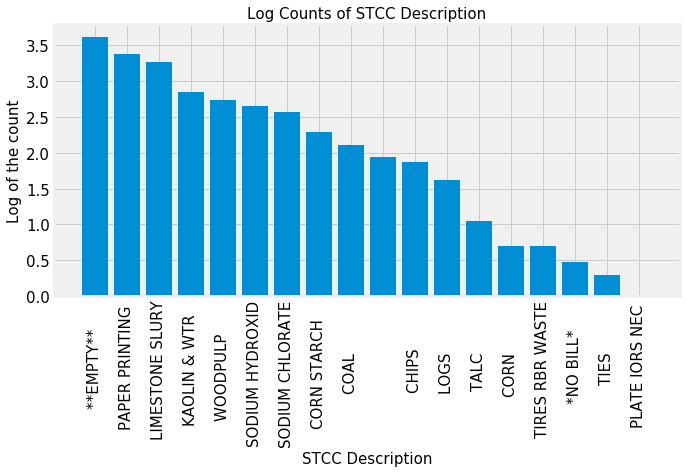

In [28]:
col = 'STCC Description'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

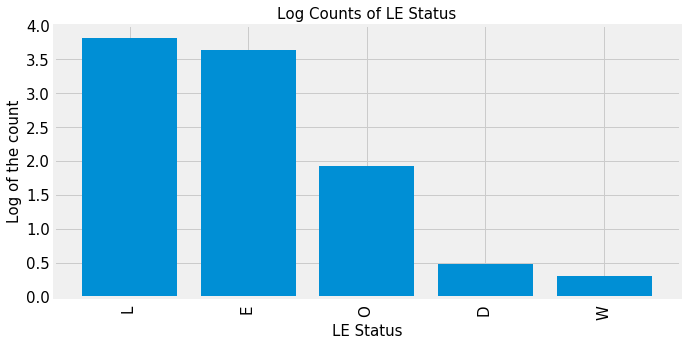

In [29]:
col = 'LE Status'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

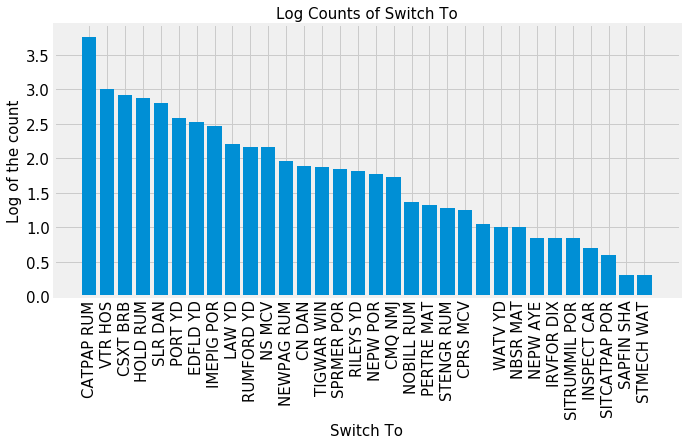

In [30]:
col = 'Switch To'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

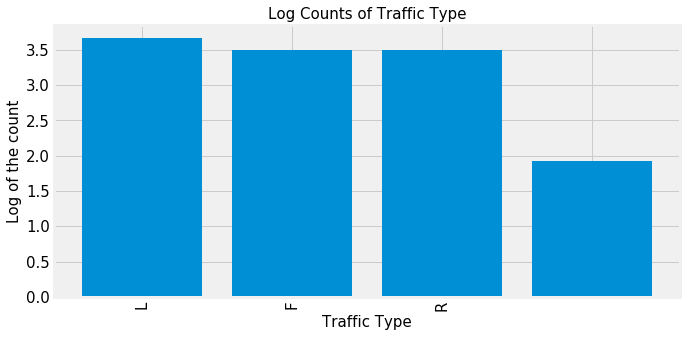

In [31]:
col = 'Traffic Type'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

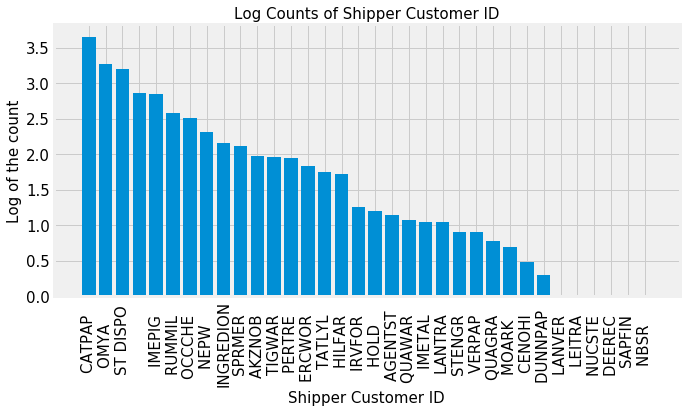

In [32]:
col = 'Shipper Customer ID'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

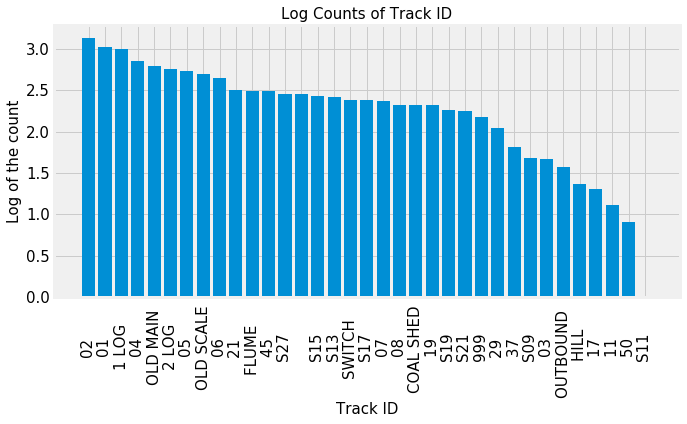

In [33]:
col = 'Track ID'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);

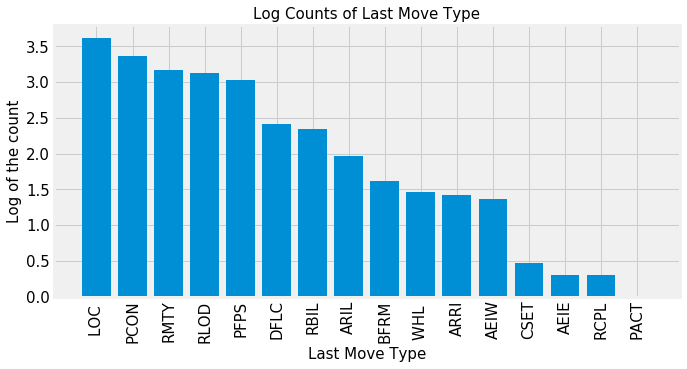

In [34]:
col = 'Last Move Type'
fig,ax = plt.subplots(figsize=(10,5))

data= df_trains[col].value_counts()

fontsize=15
ax.bar(data=data, x=data.index, height=np.log10(data))
ax.set_xlabel(col, fontsize=fontsize)
ax.set_ylabel('Log of the count', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title(str("Log Counts of "+col),fontsize=fontsize)
plt.xticks(rotation=90);